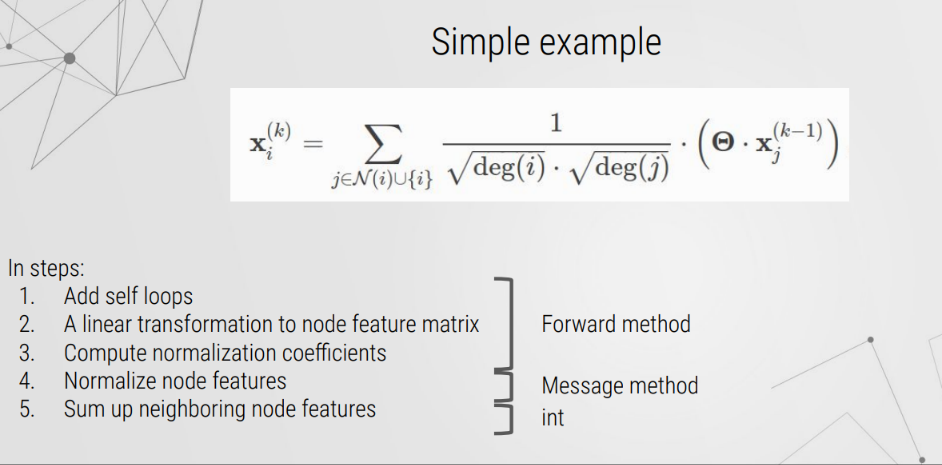

In [56]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import torch
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import to_networkx

os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [175]:
edge_index = torch.LongTensor([[0, 0, 1, 2, 4, 4, 4], [1, 2, 2, 3, 0, 2, 3]])
feat = torch.FloatTensor(
    [
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4],
    ]
)
data = Data(x=feat, edge_index=edge_index)
edge_attr = torch.ones(data.num_edges)
data.edge_attr = edge_attr

print(data)
nxg = to_networkx(data)

Data(x=[5, 4], edge_index=[2, 7], edge_attr=[7])


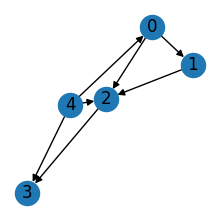

In [176]:
plt.figure(figsize=(2, 2))
nx.draw(nxg, pos=nx.spring_layout(nxg), with_labels=True)

## GCNConv
$$
        \mathbf{x}_i^{\prime} = \gamma_{\mathbf{\Theta}} \left( \mathbf{x}_i,
        \bigoplus_{j \in \mathcal{N}(i)} \, \phi_{\mathbf{\Theta}}
        \left(\mathbf{x}_i, \mathbf{x}_j,\mathbf{e}_{j,i}\right) \right),
$$
 where $\bigoplus$ denotes a differentiable, permutation invariant
    function, *e.g.*, sum, mean, min, max or mul, and
    $\gamma_{\mathbf{\Theta}}$ and $\phi_{\mathbf{\Theta}}$ denote
    differentiable functions such as MLPs.

    
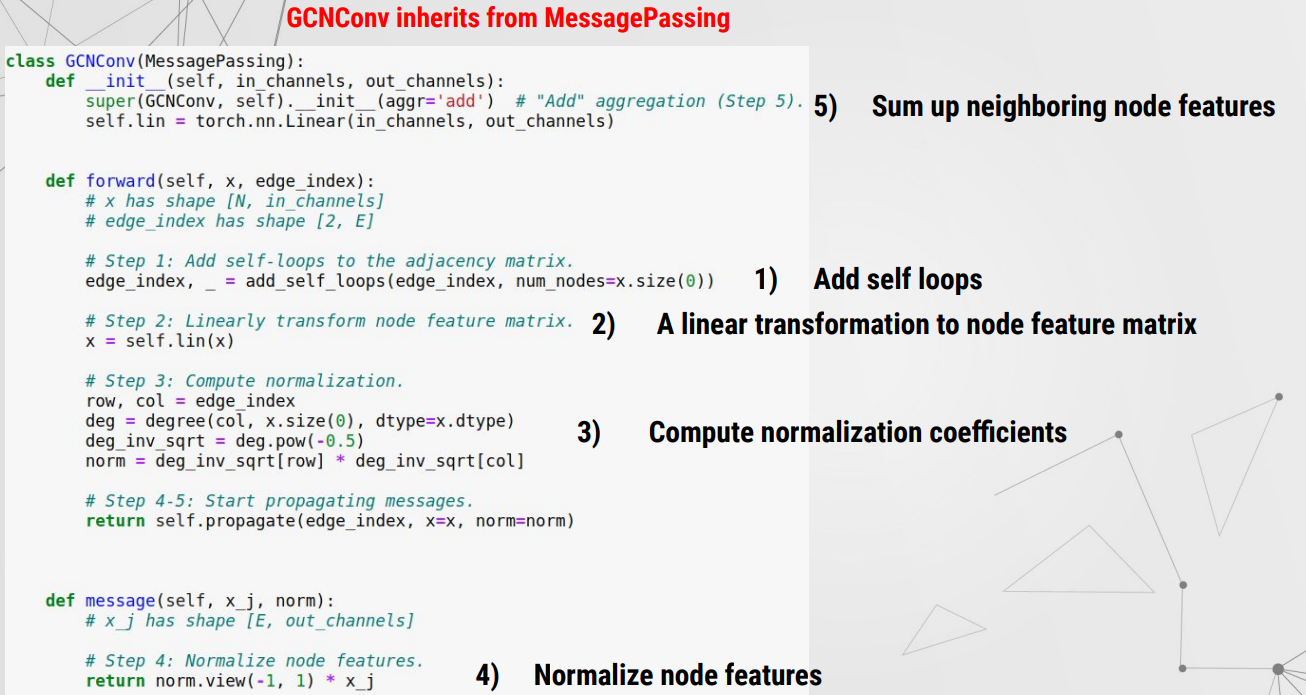


In [171]:
from torch_geometric.utils import add_self_loops, degree


class GCNConv(MessagePassing):
    def __init__(self, in_feat, out_feats):
        super(GCNConv, self).__init__(aggr="add")
        self.W = nn.Linear(in_feat, out_feats)
        torch.nn.init.ones_(self.W.weight)

        # self.bias = nn.Parameter(torch.empty(out_feats))
        # torch.nn.init.ones_(self.bias.data)

    def forward(self, x, edge_index):
        x = self.W(x)
        # 加自环为了避免度为0，分母
        edge_index, _ = add_self_loops(data.edge_index, num_nodes=data.num_nodes)

        src, dst = edge_index
        # src是源，dst是目的，degree(src)是出度，degree(dst)是入度
        in_degrees = degree(dst, num_nodes=data.num_nodes)

        deg_inv_sqrt = in_degrees.pow(-0.5)
        # deg_inv_sqrt[src]是源的入度，deg_inv_sqrt[dst]是目的的入度
        norm = deg_inv_sqrt[src] * deg_inv_sqrt[dst]

        # 传递
        out = self.propagate(edge_index, x=x, norm=norm)
        return out
        # return out + self.bias

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j
        # return会传入给aggregate，这里使用了add
        # 然后，我们调用 propagate()，它在内部调用 message()、aggregate() 和 update()。我们将节点嵌入 x 和归一化系数 norm 作为额外参数传递给信息传播。

In [172]:
in_feats = data.num_features
out_feats = 3
gcn = GCNConv(in_feats, out_feats)

In [174]:
with torch.no_grad():
    out = gcn(data.x, data.edge_index)
    print(out)

tensor([[10.8511, 10.8498, 11.6384],
        [ 1.6168,  1.6157,  2.2690],
        [10.8558, 10.8542, 11.8061],
        [15.0874, 15.0861, 15.8696],
        [15.6168, 15.6157, 16.2690]])


## TestLayer
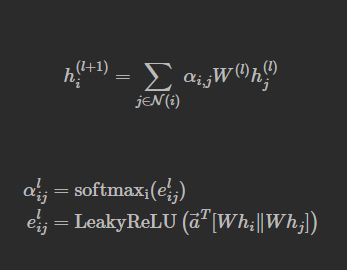

Data(x=[6, 4], edge_index=[2, 8], edge_attr=[8])


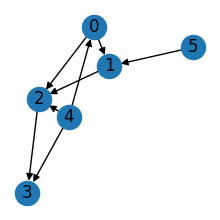

In [193]:
edge_index = torch.LongTensor(
    [
        [0, 0, 1, 2, 4, 4, 4, 5],
        [1, 2, 2, 3, 0, 2, 3, 1],
    ]
)
feat = torch.FloatTensor(
    [
        [0, 0, 0, 0],
        [1, 1, 1, 1],
        [2, 2, 2, 2],
        [3, 3, 3, 3],
        [4, 4, 4, 4],
        [5, 5, 5, 5],
    ]
)
data = Data(x=feat, edge_index=edge_index)
edge_attr = torch.ones(data.num_edges)
data.edge_attr = edge_attr

print(data)
nxg = to_networkx(data)
plt.figure(figsize=(2, 2))
nx.draw(nxg, pos=nx.spring_layout(nxg), with_labels=True)

In [588]:
from torch_scatter import scatter


class TestLayer(MessagePassing):
    def __init__(self, in_feats, out_feats):
        super(TestLayer, self).__init__(aggr="add")
        self.in_feats = in_feats
        self.out_feats = out_feats

        # Initialize learnable parameters
        self.weight = torch.nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.att = torch.nn.Parameter(torch.Tensor(1, 2 * out_feats))

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.ones_(self.weight)
        torch.nn.init.ones_(self.att)

    def forward(self, data):
        x = data.x
        edge_attr = data.edge_attr
        edge_index = data.edge_index
        hw = x @ self.weight
        # print("in forward")
        # print("x\n", x)
        # print("hw\n", hw)
        # print("----------------------------------")
        out = self.propagate(edge_index=edge_index, x=x, hw=hw)
        print(out)

    def message(self, x_i, x_j, hw_i, hw_j):
        print("in message")
        # print("x_i\n", x_i)
        print("x_j\n", x_j)
        # print("in message")
        # print("hw_i\n", hw_i)
        # print("hw_j\n", hw_j)
        # print("----------------------------------")
        return hw_i + hw_j

    def aggregate(self, ijsum, x, edge_index, hw, sb):
        # print("in aggregate")
        # print('hw_i+hw_j\n',ijsum)
        # print('x\n',x)
        # print('edge_index\n',edge_index)
        # print('hw\n',hw)
        # print("----------------------------------")
        return ijsum

    def update(self, x, hw):
        print("in update")
        print(x.sum(0))
        print("----------------------------------")
        return x

In [589]:
# MessagePassing.forward?
# MessagePassing.message?
# MessagePassing.aggregate?
# MessagePassing.propagate?

In [590]:
with torch.no_grad():
    model = TestLayer(in_feats, out_feats)
    model(data)

in message
x_j
 tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [1., 1., 1., 1.],
        [2., 2., 2., 2.],
        [4., 4., 4., 4.],
        [4., 4., 4., 4.],
        [4., 4., 4., 4.],
        [5., 5., 5., 5.]])
in update
tensor([136., 136., 136.])
----------------------------------
tensor([[ 4.,  4.,  4.],
        [ 8.,  8.,  8.],
        [12., 12., 12.],
        [20., 20., 20.],
        [16., 16., 16.],
        [24., 24., 24.],
        [28., 28., 28.],
        [24., 24., 24.]])


In [600]:
x = torch.tensor(
    [
        [0.0, 0.0, 0.0, 0.0],
        [0.0, 0.0, 0.0, 0.0],
        [1.0, 1.0, 1.0, 1.0],
        [2.0, 2.0, 2.0, 2.0],
        [4.0, 4.0, 4.0, 4.0],
        [4.0, 4.0, 4.0, 4.0],
        [4.0, 4.0, 4.0, 4.0],
        [5.0, 5.0, 5.0, 5.0],
    ]
)

In [632]:
scatter(src=x,index=torch.tensor([5,1,4,4,3,5,1,4])
        ,dim=0,reduce='sum',dim_size=data.num_nodes)

tensor([[0., 0., 0., 0.],
        [4., 4., 4., 4.],
        [0., 0., 0., 0.],
        [4., 4., 4., 4.],
        [8., 8., 8., 8.],
        [4., 4., 4., 4.]])